In [1]:
# install
# pip install novosparc

In [2]:
# imports
import novosparc as ns

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr

import random
random.seed(0)

In [3]:
import cv2 as cv
from skimage import io, color
import torch
from torch.nn import functional as F
import json

In [4]:
%cd /lustre03/project/6075067/calcium/2021/CeLEry

/lustre03/project/6075067/calcium/2021/CeLEry


In [5]:
from data.MouseBrain.MP1_SVG import d_g

In [6]:
import sys
sys.path.append('/lustre03/project/6075067/calcium/2021/CeLEry/CeLEry_package')

import CeLEry as cel
cel.__version__

'1.1.2'

##  1. Data Preperation
### Load MouseBarin Data Section 1: Spatial Transcriptomic Data


In [7]:
dataSection1full = sc.read("data/MouseBrain/MP1_sudo.h5ad")
genename = dataSection1full.var['genename']

In [8]:
# Get the gene list from the pre-screening
genelistlist = [d_g[i] for i in  range(len(d_g))]  # transform dictionary to a list of lists
genelist = sum(genelistlist, [])  # merge the list of lists
genelistuni = list( dict.fromkeys(genelist) )   # remove duplicates

genelistindex = [genename[genename == i].index[0] for i in genelistuni if  len(genename[genename == i])>0]


In [9]:
#Read in hitology image
ImageSec1=io.imread("data/MouseBrain/V1_Mouse_Brain_Sagittal_Posterior_image.tif")
ImageSec1sub = ImageSec1[3000:7000,6200:10500,:]
# spc.printimage (ImageSec1sub, "../output/CeLEry/imageselect")


In [10]:
imgray = cv.cvtColor(ImageSec1sub, cv.COLOR_BGR2GRAY)
imgray2 = imgray.copy()
imgray2[imgray2<160] = 0
imgray2[imgray2>160] = 255

## Take the subset of dataSection1
xcords = dataSection1full.obs["x"].to_numpy()
ycords = dataSection1full.obs["y"].to_numpy()

Section1Sub = dataSection1full[(xcords>=3000) & (xcords<7000) & (ycords>=6200) & (ycords<10500), genelistindex]
Section1Sub.obs = Section1Sub.obs/50
Section1Sub.obs = Section1Sub.obs.astype(int)
Section1Sub.obs["inner"] = 0

## Quality Control

for i in range(Section1Sub.obs.shape[0]):
    xi = Section1Sub.obs["x"][i]
    yi = Section1Sub.obs["y"][i]
    subarea = np.mean(imgray2[(xi*50-3000):(xi*50+50-3000), (yi*50-6200):(yi*50+50-6200)])
    if subarea<140 or xi*50>6000:
         Section1Sub.obs["inner"].iloc[i] = 1
    if yi*50>10200 or xi*50<1000:
         Section1Sub.obs["inner"].iloc[i] = 0

Section1Sub = Section1Sub[Section1Sub.obs["inner"] == 1]


Load the index of holdoff. Making sure all methods are comparable.

In [11]:
cel.get_zscore(Section1Sub)

# random.seed(2021)
# torch.manual_seed(2021)
# np.random.seed(2021)

# index10 = random.sample(range(Section1Sub.shape[0]), int(Section1Sub.shape[0]*0.1))
# index30 = random.sample(range(Section1Sub.shape[0]), int(Section1Sub.shape[0]*0.3))
# index50 = random.sample(range(Section1Sub.shape[0]), int(Section1Sub.shape[0]*0.5))

# np.save("../output/CeLEry/index10.npy", index10)
# np.save("../output/CeLEry/index30.npy", index30)
# np.save("../output/CeLEry/index50.npy", index50)

index10 = np.load("output/CeLEry/index10.npy")
index30 = np.load("output/CeLEry/index30.npy")
index50 = np.load("output/CeLEry/index50.npy")


In [12]:
# split the data into training and testing data

# 10% hold off
Section1train10 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index10)),]
Section1test10 = Section1Sub[list(set(index10)),]

# 30% hold off
Section1train30 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index30)),]
Section1test30 = Section1Sub[list(set(index30)),]

# 50% hold off
Section1train50 = Section1Sub[list(set(range(Section1Sub.shape[0]))-set(index50)),]
Section1test50 = Section1Sub[list(set(index50)),]


In [17]:
def novosparc_run_old(holdoff, datatrain, datatest):
    random.seed(2021)
    torch.manual_seed(2021)
    np.random.seed(2021)
    ## Running novosparc
    locations_apriori = datatrain.obs[['x', 'y']].values
    tissue = ns.cm.Tissue(dataset=datatest, locations=locations_apriori)
    num_neighbors_s = num_neighbors_t = 5
    
    dge_rep = None # a representation of cells gene expression
    sc.pp.highly_variable_genes(datatest)
    is_var_gene = datatest.var['highly_variable']
    var_genes = list(is_var_gene.index[is_var_gene])
    dge_rep = datatest.to_df()[var_genes]
    
    tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)
    
    tissue.reconstruct(alpha_linear=0, epsilon=5e-3)
    
    location_pred = tissue.gw
    
    ## For each cell  of the "scRNA", find the predicted location on Spatial map
    S1_xmax = datatrain.obs['x'].max() + 1
    S1_xmin = datatrain.obs['x'].min() - 1
    S1_ymax = datatrain.obs['y'].max() + 1
    S1_ymin = datatrain.obs['y'].min() - 1
    #
    S2_xmax = datatest.obs['x'].max() + 1
    S2_xmin = datatest.obs['x'].min() - 1
    S2_ymax = datatest.obs['y'].max() + 1
    S2_ymin = datatest.obs['y'].min() - 1
    ## Normalize the coordinates of both Sections
    spx = (datatrain.obs.iloc[:,0] - S1_xmin) / (S1_xmax - S1_xmin)
    spy = (datatrain.obs.iloc[:,1] - S1_ymin) / (S1_ymax - S1_ymin)
    truex = (datatest.obs.iloc[:,0] - S2_xmin) / (S2_xmax - S2_xmin)
    truey = (datatest.obs.iloc[:,1] - S2_ymin) / (S2_ymax - S2_ymin)
    #
    total_loss_tg = []
    coords_predict = np.zeros((datatest.obs.shape[0],4))

    for i in range(location_pred.shape[0]):
        bestindex = np.argmax(location_pred[i,:])
        truth = torch.FloatTensor([truex[i],truey[i]])
        pred = torch.FloatTensor([spx[bestindex],spy[bestindex]])
        coords_predict[i,0:2] = pred
        coords_predict[i,2:4] = truth
        loss = F.mse_loss(truth,pred)
        total_loss_tg.append(loss)
    #
    losstotal_itemize = [x.item() for x in total_loss_tg]
    losstotal = sum(losstotal_itemize)
    print('Loss for enhancement data only:{:.4f}'.format(float(losstotal)))
    #
    np.savetxt("output/CeLEry/novosparc/location_{holdoff}_predict.csv".format(holdoff = holdoff), coords_predict)
    #
    cel.RelocationPlot(coords_predict, datatest.obs[["x","y"]], filename = "output/CeLEry/novosparc/location_{holdoff}".format(holdoff = holdoff))
    SSIM_result =  cel.get_SSIM(coords_predict, referadata = datatest, trainAnn = datatrain, referlocation = datatest.obs[["x","y"]], genelist = range(datatest.X.shape[1]))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][0,:,:,0]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_1".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][0,:,:]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_anchor_1".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][1,:,:,0]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_2".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][1,:,:]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_anchor_2".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][2,:,:,0]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_3".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][2,:,:]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_anchor_3".format(holdoff = holdoff))
    np.save("output/CeLEry/novosparc/novosparc_{holdoff}_SSIM.npy".format(holdoff = holdoff), np.array(SSIM_result[0]))
    np.save("output/CeLEry/novosparc/novosparc_{holdoff}_cor.npy".format(holdoff = holdoff), np.array(SSIM_result[3]))
    np.save("output/CeLEry/novosparc/novosparc_{holdoff}_MSE.npy".format(holdoff = holdoff), np.array(SSIM_result[4]))
    del SSIM_result
    #
    # result_tg = sc.AnnData(X= np.expand_dims(np.array(losstotal_itemize),  axis = 1))
    # result_tg.obs = datatest.obs[["x","y"]]
    # cel.getGeneImg(result_tg, emptypixel = -0.1)
    # cel.plotGeneImg(result_tg.GeneImg[0,:,:],filename = "output/CeLEry/novosparc/imgDNNnovosparc_{holdoff}".format(holdoff = holdoff), range = (-0.1,0.6))
    #
    #
    results = {"MSE":str(round(losstotal,4))}
    with open("output/CeLEry/novosparc/novosparc_results_{holdoff}.txt".format(holdoff = holdoff), 'w') as file:
        file.write(json.dumps(results))


In [21]:
datatrain = Section1train10

In [26]:
atlas_genes = datatrain.var
markers = list(set(atlas_genes.values[:,0]))
num_genes = len(markers)
atlas_matrix = datatrain.to_df().values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=markers)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)


In [29]:
datatest = Section1test10
locations_apriori = datatrain.obs[['x', 'y']].values
tissue = ns.cm.Tissue(dataset=datatest, locations=locations_apriori)
num_neighbors_s = num_neighbors_t = 5

tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)

Setting up for reconstruction ... done ( 11.96 seconds )


358

In [34]:
def novosparc_run(holdoff, datatrain, datatest):
    random.seed(2021)
    torch.manual_seed(2021)
    np.random.seed(2021)
    ## Running novosparc
    locations_apriori = datatrain.obs[['x', 'y']].values
    tissue = ns.cm.Tissue(dataset=datatest, locations=locations_apriori)
    num_neighbors_s = num_neighbors_t = 5
    
    # params for linear cost
    atlas_genes = datatrain.var
    markers = list(set(atlas_genes.values[:,0]))
    num_genes = len(markers)
    atlas_matrix = datatrain.to_df().values
    markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=markers)
    markers_to_use = np.concatenate(markers_idx.loc[markers].values)

    tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)
          
    tissue.reconstruct(alpha_linear=0.8, epsilon=5e-3)
    
    location_pred = tissue.gw
    
    ## For each cell  of the "scRNA", find the predicted location on Spatial map
    S1_xmax = datatrain.obs['x'].max() + 1
    S1_xmin = datatrain.obs['x'].min() - 1
    S1_ymax = datatrain.obs['y'].max() + 1
    S1_ymin = datatrain.obs['y'].min() - 1
    #
    S2_xmax = datatest.obs['x'].max() + 1
    S2_xmin = datatest.obs['x'].min() - 1
    S2_ymax = datatest.obs['y'].max() + 1
    S2_ymin = datatest.obs['y'].min() - 1
    ## Normalize the coordinates of both Sections
    spx = (datatrain.obs.iloc[:,0] - S1_xmin) / (S1_xmax - S1_xmin)
    spy = (datatrain.obs.iloc[:,1] - S1_ymin) / (S1_ymax - S1_ymin)
    truex = (datatest.obs.iloc[:,0] - S2_xmin) / (S2_xmax - S2_xmin)
    truey = (datatest.obs.iloc[:,1] - S2_ymin) / (S2_ymax - S2_ymin)
    #
    total_loss_tg = []
    coords_predict = np.zeros((datatest.obs.shape[0],4))

    for i in range(location_pred.shape[0]):
        bestindex = np.argmax(location_pred[i,:])
        truth = torch.FloatTensor([truex[i],truey[i]])
        pred = torch.FloatTensor([spx[bestindex],spy[bestindex]])
        coords_predict[i,0:2] = pred
        coords_predict[i,2:4] = truth
        loss = F.mse_loss(truth,pred)
        total_loss_tg.append(loss)
    #
    losstotal_itemize = [x.item() for x in total_loss_tg]
    losstotal = sum(losstotal_itemize)
    print('Loss for enhancement data only:{:.4f}'.format(float(losstotal)))
    #
    np.savetxt("output/CeLEry/novosparc/location_{holdoff}_predict.csv".format(holdoff = holdoff), coords_predict)
    #
    cel.RelocationPlot(coords_predict, datatest.obs[["x","y"]], filename = "output/CeLEry/novosparc/location_{holdoff}".format(holdoff = holdoff))
    SSIM_result =  cel.get_SSIM(coords_predict, referadata = datatest, trainAnn = datatrain, referlocation = datatest.obs[["x","y"]], genelist = range(datatest.X.shape[1]))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][0,:,:,0]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_1".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][0,:,:]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_anchor_1".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][1,:,:,0]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_2".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][1,:,:]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_anchor_2".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[1][2,:,:,0]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_3".format(holdoff = holdoff))
    cel.plotGeneImg(cel.centralize2(SSIM_result[2][2,:,:]), filename = "output/CeLEry/novosparc/novosparc_{holdoff}_SSIM_anchor_3".format(holdoff = holdoff))
    np.save("output/CeLEry/novosparc/novosparc_{holdoff}_SSIM.npy".format(holdoff = holdoff), np.array(SSIM_result[0]))
    np.save("output/CeLEry/novosparc/novosparc_{holdoff}_cor.npy".format(holdoff = holdoff), np.array(SSIM_result[3]))
    np.save("output/CeLEry/novosparc/novosparc_{holdoff}_MSE.npy".format(holdoff = holdoff), np.array(SSIM_result[4]))
    del SSIM_result
    #
    # result_tg = sc.AnnData(X= np.expand_dims(np.array(losstotal_itemize),  axis = 1))
    # result_tg.obs = datatest.obs[["x","y"]]
    # cel.getGeneImg(result_tg, emptypixel = -0.1)
    # cel.plotGeneImg(result_tg.GeneImg[0,:,:],filename = "output/CeLEry/novosparc/imgDNNnovosparc_{holdoff}".format(holdoff = holdoff), range = (-0.1,0.6))
    #
    #
    results = {"MSE":str(round(losstotal,4))}
    with open("output/CeLEry/novosparc/novosparc_results_{holdoff}.txt".format(holdoff = holdoff), 'w') as file:
        file.write(json.dumps(results))


Setting up for reconstruction ... done ( 11.57 seconds )
Reconstructing spatial information with 358 markers: 582 cells and 5242 locations ... 
Trying with epsilon: 5.00e-03
Loss for enhancement data only:0.8232


100%|██████████| 358/358 [00:05<00:00, 68.23it/s]


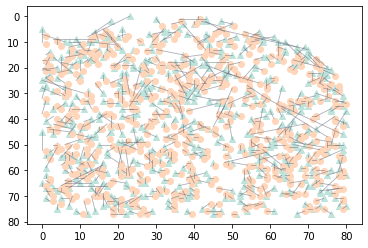

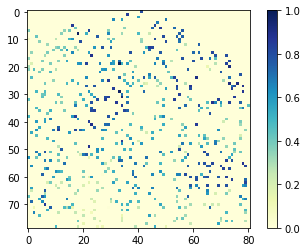

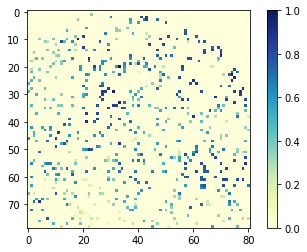

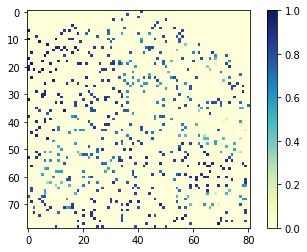

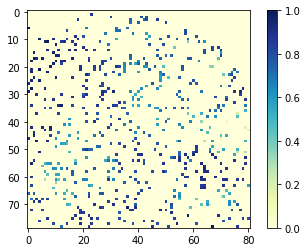

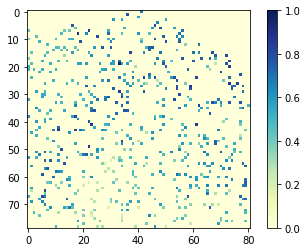

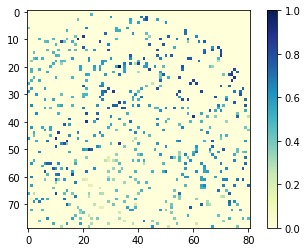

In [38]:
novosparc_run(holdoff = 10, datatrain = Section1train10, datatest = Section1test10)

Setting up for reconstruction ... done ( 8.44 seconds )
Reconstructing spatial information with 358 markers: 1747 cells and 4077 locations ... 
Trying with epsilon: 5.00e-03
Loss for enhancement data only:6.0455


100%|██████████| 358/358 [00:14<00:00, 25.06it/s]


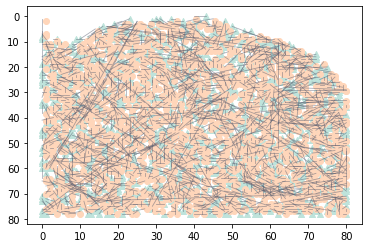

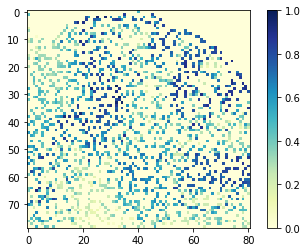

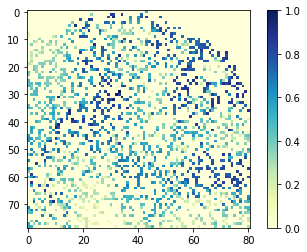

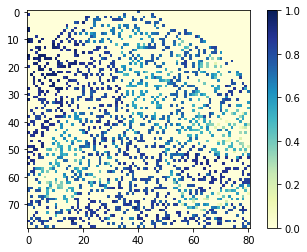

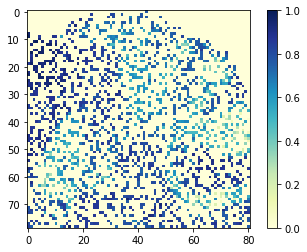

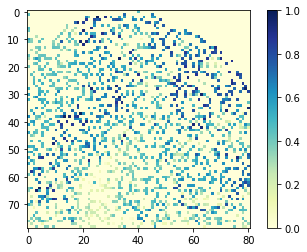

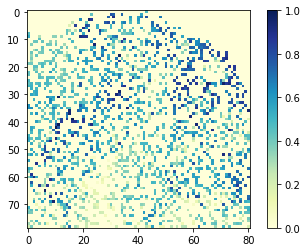

In [39]:
novosparc_run(holdoff = 30, datatrain = Section1train30, datatest = Section1test30)

Setting up for reconstruction ... done ( 7.93 seconds )
Reconstructing spatial information with 358 markers: 2912 cells and 2912 locations ... 
Trying with epsilon: 5.00e-03


/localscratch/calcium.33365382.0/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Loss for enhancement data only:10.1459


100%|██████████| 358/358 [00:23<00:00, 14.96it/s]


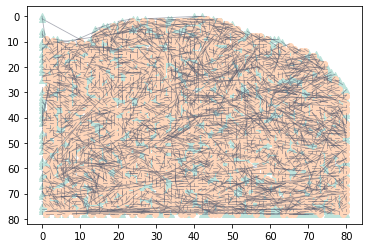

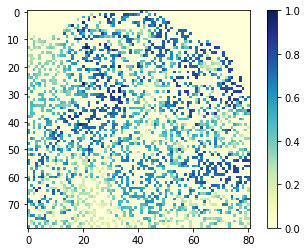

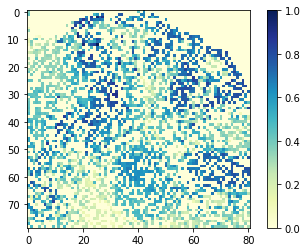

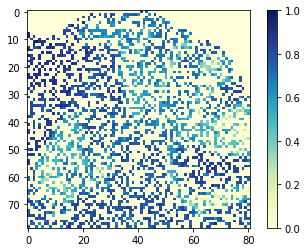

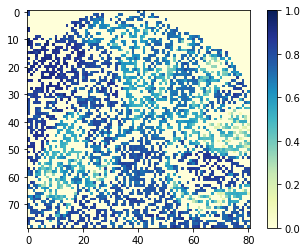

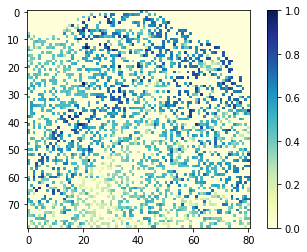

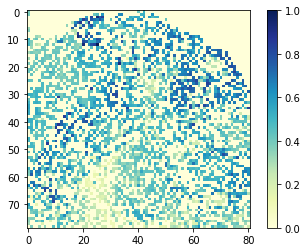

In [40]:
novosparc_run(holdoff = 50, datatrain = Section1train50, datatest = Section1test50)

In [12]:
datatrain = Section1train10
datatest = Section1test10

In [13]:
locations_apriori = datatrain.obs[['x', 'y']].values

In [14]:
locations_apriori

array([[ 61, 124],
       [ 61, 164],
       [ 61, 165],
       ...,
       [139, 202],
       [139, 203],
       [139, 204]])

In [15]:
tissue = ns.cm.Tissue(dataset=datatest, locations=locations_apriori)

In [16]:
tissue

In [17]:
num_neighbors_s = num_neighbors_t = 5

In [18]:
dge_rep = None # a representation of cells gene expression
sc.pp.highly_variable_genes(datatest)
is_var_gene = datatest.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])
dge_rep = datatest.to_df()[var_genes]

/home/calcium/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [19]:
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

Setting up for reconstruction ... 

/home/calcium/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 11.26 seconds )


In [27]:
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)

Reconstructing spatial information with 0 markers: 582 cells and 5242 locations ... 
Trying with epsilon: 5.00e-03


In [29]:
location_pred = tissue.gw

In [31]:
tissue.gw.shape

(582, 5242)

In [34]:
datatrain.obs.shape

(5242, 3)

In [21]:
## For each cell  of the "scRNA", find the predicted location on Spatial map
S1_xmax = datatrain.obs['x'].max() + 1
S1_xmin = datatrain.obs['x'].min() - 1
S1_ymax = datatrain.obs['y'].max() + 1
S1_ymin = datatrain.obs['y'].min() - 1
#
S2_xmax = datatest.obs['x'].max() + 1
S2_xmin = datatest.obs['x'].min() - 1
S2_ymax = datatest.obs['y'].max() + 1
S2_ymin = datatest.obs['y'].min() - 1

In [22]:
## Normalize the coordinates of both Sections
spx = (datatrain.obs.iloc[:,0] - S1_xmin) / (S1_xmax - S1_xmin)
spy = (datatrain.obs.iloc[:,1] - S1_ymin) / (S1_ymax - S1_ymin)
truex = (datatest.obs.iloc[:,0] - S2_xmin) / (S2_xmax - S2_xmin)
truey = (datatest.obs.iloc[:,1] - S2_ymin) / (S2_ymax - S2_ymin)

In [47]:
total_loss_tg = []
coords_predict = np.zeros((datatest.obs.shape[0],2))
    
for i in range(location_pred.shape[0]):
    bestindex = np.argmax(location_pred[i,:])
    truth = torch.FloatTensor([truex[i],truey[i]])
    pred = torch.FloatTensor([spx[bestindex],spy[bestindex]])
    coords_predict[i,:] = pred
    loss = F.mse_loss(truth,pred)
    total_loss_tg.append(loss)
    #

In [48]:
coords_predict

array([[0.5       , 0.35365853],
       [0.625     , 0.21951219],
       [0.75      , 0.98780489],
       ...,
       [0.98750001, 0.02439024],
       [0.0125    , 0.51219511],
       [0.91250002, 0.28048781]])

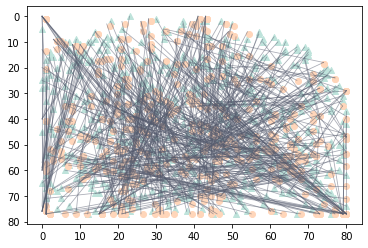

In [49]:
cel.RelocationPlot(coords_predict, datatest.obs[["x","y"]])